In [1]:
#using DifferentialEquations
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using JLD2
using Base.Threads
using Distributions
#Pkg; Pkg.add("DistributedArrays")
println("nthreads = $(nthreads())")
using Printf
#import Pkg; Pkg.add("IJuliaBell")
using IJuliaBell
using ArraysOfArrays
using SummationByPartsOperators
using LinearAlgebra

nthreads = 2


## 2D PIC Escheleton 

Here we run the 2D version of PIC. 

In [2]:
include("aux_functions/aux_functions.jl")
include("aux_functions/inidat_aux_functions.jl")


f_x

### Initial Distribution

## Initial data configurations (Particles first)

In [3]:
## initial data configurations

trys = false
thermal = false
weibel = false
weibel_norel = false
#trys = true
thermal = true
#weibel = true
#weibel_norel = true




true

In [4]:
const order = 5
const D = 2


# Particle numbers
const N_exp = 5 #7#6#5 #6
N = 10^(N_exp)

if  thermal
    #run_name = "thermal_norel_"
    run_name = "thermal_rel_"
    #data_name = "par_dis_norel_thermal_"
    data_name = "par_dis_rel_thermal_"
    J = (50,50)
    Box_x = (0.0,1.0,0.0,1.0) 
    nm = [1,1]
    Box_array = [i for i in Box_x]
    k = 2π*nm./(Box_array[2:2:end]-Box_array[1:2:end-1]) # this here is k, not \hat{k}
    alpha_exp = 1 # 2 3 8
    α = 10.0^(-alpha_exp) # 0.1 0.001
    par_f_x = (α, nm, Box_x)
    exp_Theta = 3
    θ = 10.0^(-exp_Theta)
    p_max = sqrt((1+10*θ)^2-1)
    Box_p = (-p_max,p_max,-p_max,p_max)
    par_f_p = (θ,D)
    #par_f_p_1 = (θ,1,D) #to compute the norm of f_p
    #norm = int_mid_point_f(f_p_rel, par_f_p_1, [20_000,20_000], Box_p)
    #par_f_p_rel = (θ,norm,D)
    par_init = (α, nm)
    data_name = data_name * "nm_[$(nm[1]),$(nm[2])]_"
    data_name = data_name * "alp$(alpha_exp)_N$(N_exp)_Th$(exp_Theta)"
    run_name = run_name * "Box_$(Box_x[2]-Box_x[1])x$(Box_x[4]-Box_x[3])_J_$(J[1])x$(J[2])_nm_[$(nm[1]),$(nm[2])]__Th$(exp_Theta)_alp$(alpha_exp)"
elseif weibel_norel
    run_name = "weibel_norel_"
    data_name = "par_dis_norel_weibel_"
    J = (100,100)
    Box_x = (0.0,1.0,0.0,1.0) 
    Ax = 1/2 # velocity anisotropy in the x direction
    alpha_exp = 8 # 8 so that is extremely small i.e. zero
    α = 10.0^(-alpha_exp) # 0.1 0.001
    par_f_x = (α, [0.0,0.0], Box_x)
    exp_Theta = 3
    θ = 10.0^(-exp_Theta)
    p_max = sqrt((1+10*θ)^2-1)
    Box_p = (-p_max,p_max,-p_max,p_max)
    par_f_p = (θ,D,Ax)
    par_init = (α, Ax)
    data_name = data_name * "Ax_(1d2)_"
    data_name = data_name * "alp$(alpha_exp)_N$(N_exp)_Th$(exp_Theta)"
    run_name = run_name * "Box_$(Box_x[2]-Box_x[1])x$(Box_x[4]-Box_x[3])_J_$(J[1])x$(J[2])_Ax_(1d2)_Th$(exp_Theta)_alp$(alpha_exp)"
elseif weibel 
    run_name = "weibel_"
    data_name = "par_dis_rel_weibel_"
    J = (50,50)::NTuple{2,Int64} #no parece funcionar el dar el tipo NTuple, al menos no así.
    Box_x = (0.0,1.0,0.0,1.0) 
    Ax = 25 # velocity anisotropy in the x direction
    alpha_exp = 8 # 8 so that is extremely small i.e. zero
    α = 10.0^(-alpha_exp) # 0.1 0.001
    par_f_x = (α, [0.0,0.0], Box_x)
    exp_Theta = 3
    θ1 = 10.0^(-exp_Theta)
    θ2 = Ax * θ1
    p_max = 10*θ2
    Box_p = (-p_max,p_max,-p_max,p_max)
    par_init = (α, Ax)
    @show pars_f = (θ1,θ2,Ax)
    data_name = data_name * "Ax_$(Ax)_"
    data_name = data_name * "alp$(alpha_exp)_N$(N_exp)_Th$(exp_Theta)"
    run_name = run_name * "Box_$(Box_x[2]-Box_x[1])x$(Box_x[4]-Box_x[3])_J_$(J[1])x$(J[2])_Ax_$(Ax)_Th$(exp_Theta)_alp$(alpha_exp)"
end



@show data_name 

# Evolution parameters
exp_t = 0# 1 #2
t = 0.0
t_i = 0.0
t_f = 10.0^(exp_t)
M = 101 #1001 #11 #16001# 4001 # 81 # 2001 # time steps 
M_g = 11 #8001 #400 + 1 #number of outputs, starting from the initial data
dx = differentials(Box_x,J)
@show dx_min = minimum(dx)
@show dt = (t_f-t_i)/(M-1)
@show CFL = dt/dx_min


# for plotting and other things
x_p = [dx[1]*(i-1) for i in 1:J[1]] ;
y_p = [dx[2]*(i-1) for i in 1:J[2]] ;

Dx = periodic_derivative_operator(derivative_order=1, accuracy_order=6, xmin=Box_x[1], xmax=Box_x[2], N=J[1])
Dy = periodic_derivative_operator(derivative_order=1, accuracy_order=6, xmin=Box_x[3], xmax=Box_x[4], N=J[2])
Δx = dissipation_operator(Dx;
                     #mode=D.coefficients.mode
                     #,mode=ThreadedMode()
                     )
Δy = dissipation_operator(Dy;
                     #mode=D.coefficients.mode
                     #,mode=ThreadedMode()
                     )
const σx = 0.0 #1.0 #dissipation strength
const σy = 0.0 #1.0 #dissipation strength


@show par_evolv = (t_i, t_f, M, M_g, dt)
@show par_grid = (N, J, Box_x, order)
#@show pars_f = (θ1,θ2,)



println("t_f = $(t_f), M = $M, dt = $(dt), exp_Theta = $(exp_Theta)")



run_name = run_name * "tf_$(convert(Int,10*t_f))_N$(N_exp)_M$(M)_o$(order)"
println(run_name)
println(data_name)


data_name = "par_dis_rel_thermal_nm_[1,1]_alp1_N5_Th3"
dx_min = minimum(dx) = 

0.02
dt = (t_f - t_i) / (M - 1) = 0.01
CFL = dt / dx_min = 0.5


par_evolv = (t_i, t_f, M, M_g, dt) = (0.0, 1.0, 101, 11, 0.01)
par_grid = (N, J, Box_x, order) = 

(100000, (50, 50), (0.0, 1.0, 0.0, 1.0), 5)
t_f = 1.0, M = 101, dt = 0.01, exp_Theta = 3
thermal_rel_Box_1.0x1.0_J_50x50_nm_[1,1]__Th3_alp1tf_10_N5_M101_o5
par_dis_rel_thermal_nm_[1,1]_alp1_N5_Th3


In [5]:
par_dis, data_name, pars, par_f_x, Box_x, par_f_p, Box_p = retrieve_initial_data_D("Initial_Distributions/" * data_name * ".jld2")
#@show data_name_from_inidat, pars, par_f_x, Box_x, par_f_p, Box_p

([0.09114247581419888, 0.3514029956643413, 0.024036571807407092, 0.017108981238594306, 0.9588844987316598, 0.689303696232502, -0.0029993791721266705, 0.02518387914353254, 0.09949298523198324, 0.05527865182846459  …  0.016143487849648336, -0.006758718476909703, 0.9770384880716348, 0.9252672033780165, -0.006878625252764864, -0.0002494436963886293, 0.05413955822870464, 0.6219083611253162, 0.04118477505876568, -0.03612421701826388], "par_dis_rel_thermal_nm_[1,1]_alp1_N5_Th3", (100000,), (0.1, [1, 1], (0.0, 1.0, 0.0, 1.0)), (0.0, 1.0, 0.0, 1.0), (0.001, 2), (-0.14177446878757827, 0.14177446878757827, -0.14177446878757827, 0.14177446878757827))

### Check Density

In [ ]:
plot(histogram2d(par_dis[1:2D:end],par_dis[2:2D:end], title="space distribution" ))

In [ ]:
plot(histogram2d(par_dis[3:4:end],par_dis[4:4:end] )
,aspectratio=1
,title = "momentum histogram"
)

### Check Temperature

In [6]:
T = get_temperature_rel_D(par_dis,N,D)

0.000997166214380225

In [7]:
include("aux_functions/aux_functions.jl")
#par_grid = (N, Box_x, J, 5)
#n = zeros(J)
#get_density_2D!(par_dis, n, par_grid)

get_density_2D_trans = Density2DTrans(N, J)
n = get_density_2D_trans(Val(order), Box_x, par_dis)


50×50 Matrix{Float64}:
 1.23944   1.14781   0.999572  0.98001   …  1.18663   1.22786   1.25463
 1.20866   1.09533   1.04061   0.998931     1.2597    1.3015    1.29692
 1.20276   1.05162   1.06156   1.02937      1.17282   1.25593   1.29675
 1.12977   1.07575   1.10152   1.028        1.08708   1.11599   1.18759
 1.00059   1.03775   1.07624   1.01101      1.11215   1.0407    1.1179
 1.02387   1.02798   0.998328  0.970457  …  1.10482   1.14417   1.19276
 1.07667   1.02983   0.973566  0.926269     1.09694   1.14548   1.18426
 1.11231   0.960635  0.977528  0.956829     1.02992   1.10544   1.19986
 1.05376   0.940449  1.03152   1.03348      1.0548    1.16012   1.17132
 1.06112   1.02624   1.0625    1.0455       1.10445   1.18438   1.1571
 ⋮                                       ⋱                      
 0.946622  0.952518  1.04453   1.11578      0.924557  1.01965   1.06767
 1.05769   1.15363   1.23043   1.18888      1.02726   0.94965   1.02571
 1.14535   1.18773   1.21826   1.16211      1.0182

In [ ]:
plot_matrix(n)

In [ ]:
plot(n[:,2])

### Check Normalization

In [8]:
sum(n)/prod(J)

1.0

### Check Current

In [9]:
par_grid = (N, J, Box_x, 5)
#S = [0.0::Float64 for l in 1:2, i in 1:J[1], j in 1:J[2]]
#S_new  = [0.0::Float64 for i in 1:J[1], j in 1:J[2], l in 1:2]
#TS = zeros(Float64,(2,J...,nthreads()))

#par_current_threads_S = (par_grid, TS)

#get_current_threads_2D!(par_dis, S, par_current_threads_S)
#S_new = get_current_2D_trans(Val(order), N, J, Box_x, par_dis)


get_current_2D_trans = Current2DTrans(N, J)
S = get_current_2D_trans(Val(order), Box_x, par_dis)
@show sum(S[:,:,1])

sum(S[:, :, 1]) = -5.551115123125783e-17


-5.551115123125783e-17

In [ ]:
surface(y_p,x_p, S[:,:,1])

## Electric and Magnetic initial data

In [10]:
# We prescrive a constant magnetic field and the E is just a solution from Poisson's equations. 

B0 = 0.0 #initial magnetic field

B = [B0 for i in 1:J[1], j in 1:J[2]]

run_name = run_name * "_B0_$(convert(Int,B0))"

"thermal_rel_Box_1.0x1.0_J_50x50_nm_[1,1]__Th3_alp1tf_10_N5_M101_o5_B0_0"

In [11]:
E = Array{Float64,3}(undef,(2,J...))
#ρ = n.-1.0/prod(J)
ρ = n.-1.0
@show sum(ρ)
get_E!(E,ρ,Box_x);

sum(ρ) = 1.3455903058456897e-13


In [ ]:
surface(y_p,x_p, E[2,:,:])

In [ ]:
plot(x_p, E[1,:,5])

In [12]:
average_outputs = false # detailed output (for runs which are too long)
full_outputs = false
animation = false # to run animations
phase_space_show = false #show phase space diagrams
#phase_space_show = true
remote_server = false # if run in remote_server as a script avoid all plots 
save_plots = false # put true is you want so save your plots.
full_outputs = true
animation = true

true

We build the initial data:

In [13]:
u = Vector{Float64}(undef, 4N + 3*prod(J)); # contains r, v and E and B

du = Vector{Float64}(undef, 4N + 3*prod(J)); # contains r, v and E

u[1:4N] = par_dis 

Fu = view(u,4N+1:4N+3*prod(J))

F = reshape(Fu,3,J...)

#F = view(u[4N+1:end],3,J...)
F[1:2,:,:] = E
F[3,:,:] = B;

# the total electric energy is:

(norm(E)^2 + norm(B)^2)*prod(dx)
#u
#F[3,:,:]



6.019042488598391e-5

In [ ]:
#surface(y_p,x_p,F[1,:,:])

In [14]:
Energy_Ks, Energy_Es = get_energy_rel(u,(Box_x, N, J))

(0.000996178475273901, 3.0095212442991956e-5)

In [ ]:
#surface(y_p,x_p,F[3,:,:])

In [ ]:
u[4N+2*prod(J)+1:end]
#u[4N+1:end-prod(J)]

With the particle distribution we construct the initial data for the electric field. For that first we compute de density, using different types of particles (order).

### What follows are characterizations of the initial data properties.

In [15]:

Coordinate_test(u,Box_x,N)

#println("n_total = $(sum(n .- 1.0))")
#println("v_total = $(sum(u[N+1:2N]))")
#println("E_total = $(sum(E_i))")

#println("S_total = $(sum(S))")

test passed


## TIME Evolution: 

Now we make the time evolution:

1. we define parameters and vectors where to upload data to study the time evolution: Kinetic Energy, Electric field Energy, Total Electric field, total velocity (momentum), total density, total charge current.

2. we save a vector with the particle phase space, this can be a lot of memory!

In [16]:
if nthreads() > 1
#TS = zeros(Float64, (2,J...,nthreads()))
#p_RHS_D = (N, J, Box_x, order, n, S, du, get_density_2D!, get_current_threads_2D!, Interpolate_EBv_1, TS, Dx, Δx, σx, Dy, Δy, σy) ;
p_RHS_D = (N, J, Box_x, order, n, S, du, get_density_2D!, get_current_2D_trans, Interpolate_EBv_1, Dx, Δx, σx, Dy, Δy, σy) ;
else
p_RHS_D = (N, J, Box_x, order, n, S, du, get_density_2D!, get_current_rel_2D!, Interpolate_EBv_1, Dx, Δx, σx, Dy, Δy, σy) ;
end


(100000, (50, 50), (0.0, 1.0, 0.0, 1.0), 5, [1.2394396230938525 1.1478078023384408 … 1.227857577296267 1.2546301075876518; 1.2086576223020873 1.0953294259710127 … 1.3014979663854396 1.296915972435618; … ; 0.9974838851070467 1.0595864673660784 … 1.0025643140225033 1.0294802726937737; 1.1122407092981494 1.1018359683338048 … 1.080278888330175 1.1034543700875963], [0.0016870587809040124 0.0027070806514163763 … 0.00048800801607582856 0.00041814294523151083; 0.0044693778349913366 0.003324903453866744 … -0.003384192389302726 0.0012521723282148689; … ; -0.0002977399759385429 0.002110266549504944 … -0.00400029671010306 -0.002400679765392091; 0.0007733764176560673 0.0023015409198245615 … -0.0011878746441331936 -0.0008071496011154491;;; 0.0038084757368894748 -0.0010704576491352483 … 0.0013061706669556473 0.0035486694494189248; 0.0006556892098904965 0.0008538192917955333 … -0.000669079789119781 0.0002743119727536776; … ; -0.0019390553957146948 -0.006162999301646214 … -0.0014256368578513489 -0.0001

In [17]:
t = 0.0
j = 1

run_pars = Dict("run_name" => run_name, "par_grid" => par_grid, "par_evolv" => par_evolv, "p_Ini" => (par_f_x, par_f_p))

if full_outputs
    run_name = run_name * "_full"
elseif average_outputs
    run_name = run_name * "_ave"
end

file_name = "Results/"* run_name * ".jld2"
#rm(file_name)




save(file_name, run_pars)

if false # solo para testear
file = jldopen(file_name, "r+")
close(file)
end

if full_outputs
    field_name = "u"
    tiempo = @sprintf("%05d", j)
    jldopen(file_name, "a+") do file
        file[field_name * "/u_$(tiempo)"] = u;
    end
end

if average_outputs
    load_averages(file_name, j, par_grid, pars_f)
end

if animation
    par = Array{Float64,2}(undef,M_g,length(u));
    par[1,:] = u[:]
end

407500-element Vector{Float64}:
  0.09114247581419888
  0.3514029956643413
  0.024036571807407092
  0.017108981238594306
  0.9588844987316598
  0.689303696232502
 -0.0029993791721266705
  0.02518387914353254
  0.09949298523198324
  0.05527865182846459
  ⋮
  0.004499126645905786
  0.0015672601796579428
  0.0
  0.004991705380794855
  0.0005947684702981573
  0.0
  0.005217944824638738
 -0.00026098328051208524
  0.0

In [ ]:
#RHS_D(u,t,p_RHS_D)

In [18]:
include("aux_functions/aux_functions.jl")
for k in 2:M
  RK4_Step!(RHS_D,u,t,dt,p_RHS_D)
  #global u = [make_periodic!(u[1:4N],Box_x); u[4N+1:end]]
  # make_periodic!(u,Box_x,N) # done inside the RHS_D function at every RK step
  #filter_constant!(u[2N+1:end])
  global t = t + dt
  if (k-1) % (M÷(M_g-1)) == 0
    local j = (k-1)÷(M÷(M_g-1))+1
    make_periodic!(u,Box_x,N) # just to save the correct data
    global Energy_Ks, Energy_Es = get_energy_rel(u,(Box_x, N, J))

    if average_outputs
      load_averages(file_name, j, par_grid, pars_f)
    end

    if full_outputs
        local tiempo = @sprintf("%05d", j)
        jldopen(file_name, "a+") do file
            file[field_name * "/u_$(tiempo)"] = u
      end
    end

    println("j = $j , t = $t, k = $k, nthreads = $(nthreads()), Total_Energy = $(Energy_Ks + Energy_Es), E_Energy = $(Energy_Es)")

    if animation
      par[j,:] = u[:]
    end
  end
end

j = 2 , t = 0.09999999999999999, k = 11, nthreads = 2, Total_Energy = 0.0010262728914333028, E_Energy = 2.9714111866971734e-5


j = 3 , t = 0.20000000000000004, k = 21, nthreads = 2, Total_Energy = 0.0010262709537564709, E_Energy = 2.872013614395717e-5


j = 4 , t = 0.3000000000000001, k = 31, nthreads = 2, Total_Energy = 0.0010262682757035276, E_Energy = 2.716124336714856e-5


j = 5 , t = 0.4000000000000002, k = 41, nthreads = 2, Total_Energy = 0.0010262652224027626, E_Energy = 2.5108613581837788e-5


j = 6 , t = 0.5000000000000002, k = 51, nthreads = 2, Total_Energy = 0.0010262620002891446, E_Energy = 2.2652951955153048e-5


j = 7 , t = 0.6000000000000003, k = 61, nthreads = 2, Total_Energy = 0.0010262586384037166, E_Energy = 1.9902146645947464e-5


j = 8 , t = 0.7000000000000004, k = 71, nthreads = 2, Total_Energy = 0.001026255044067818, E_Energy = 1.6973953117619925e-5


j = 9 , t = 0.8000000000000005, k = 81, nthreads = 2, Total_Energy = 0.0010262514082212423, E_Energy = 1.399433043018053e-5


j = 10 , t = 0.9000000000000006, k = 91, nthreads = 2, Total_Energy = 0.0010262479897284011, E_Energy = 1.1088048086678309e-5


j = 11 , t = 1.0000000000000007, k = 101, nthreads = 2, Total_Energy = 0.001026244896030512, E_Energy = 8.375978394620935e-6


In [ ]:
j = 11

Plots.scatter(par[j,1:2D:4N], par[j,2:2D:4N], ts=0.2
, thickness_scaling = 0.3
, markersize = 0.3
, title = "space", legend =:false)

#png("weibel_space_t=10")

In [19]:
#include("aux_functions/aux_functions.jl")


#make_periodic!(par[M_g,:],Box_x,N)
Coordinate_test(par[M_g,:],Box_x,N)

test passed


In [ ]:
j = 11

histogram2d(par[j,1:2D:4N], par[j,2:2D:4N], ts=0.2
, thickness_scaling = 0.3
, markersize = 0.3
, title = "space", legend =:false)

In [ ]:
j = 11
Plots.scatter(par[j,3:2D:4N], par[j,4:2D:4N], ts=0.2
, thickness_scaling = 0.3
, markersize = 0.3
, title = "momentum", legend =:false)

#png("weibel_momentum_t=10")

In [26]:
j = M_g
Fuj = view(par[j,:],4N+1:4N+3*prod(J))

Fj = reshape(Fuj,3,J...)

#F = view(u[4N+1:end],3,J...)
Ej = Fj[1:2,:,:]
Bj = Fj[3,:,:];

#surface(y_p,x_p,Ej[2,:,:])
#surface(y_p,x_p,Bj[:,:])

#norm(Bj)

50×50 Matrix{Float64}:
 -1.36199e-6    2.28717e-5    4.88246e-5  …   0.000109498   7.31621e-5
 -7.43643e-5    2.00051e-5    1.54264e-5      1.22563e-5   -4.16032e-5
  2.7759e-6     2.15793e-5   -2.28803e-5      8.57689e-5    1.57071e-5
 -7.40054e-6    3.18215e-6   -3.48753e-5      2.25015e-5   -5.53281e-5
  7.80588e-6    3.52258e-5    1.17231e-5      4.80076e-5    2.89812e-6
 -4.80519e-5    3.37997e-6   -2.06586e-5  …  -1.66506e-5   -8.02916e-5
  6.81557e-6    1.72048e-5    6.96234e-6     -5.82289e-5   -2.39589e-5
 -4.81151e-5   -3.51164e-5   -4.28477e-5     -8.27847e-5   -7.18279e-5
 -4.23991e-5    5.84114e-6   -1.16633e-5     -7.72703e-5   -7.68574e-5
 -5.97694e-5   -2.65044e-5   -7.84406e-5     -9.88636e-6   -4.05393e-5
  ⋮                                       ⋱                
 -6.28165e-5   -0.000122462  -2.34103e-5     -1.83916e-5   -4.31156e-5
  5.38241e-5   -1.26061e-5    5.32241e-5      3.35411e-5   -7.43977e-6
  5.86488e-5   -1.63694e-5   -1.53685e-5      2.95272e-6    5.231

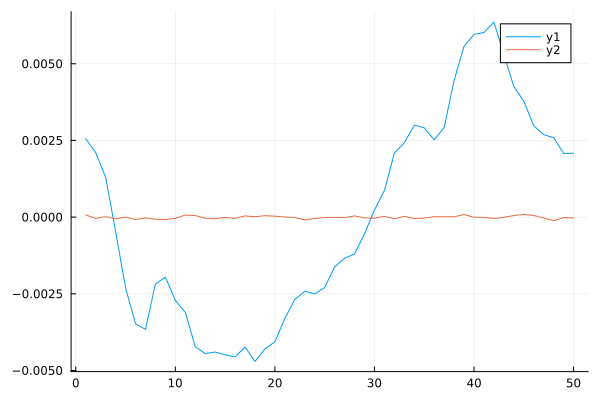

In [27]:
plot(Ej[1,:,50])
plot!(Bj[:,50])

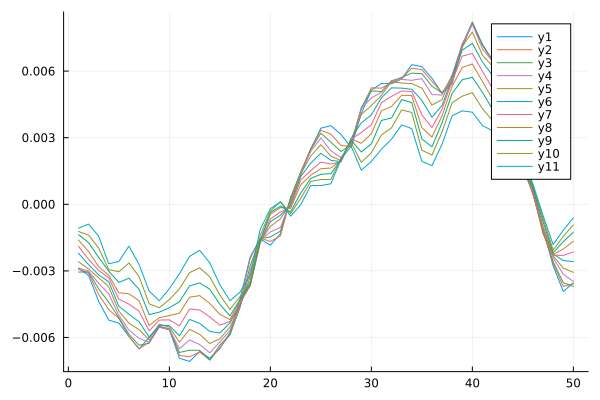

In [28]:
l = 1
P = 5
plot()
for j in 1:M_g
    Fuj = view(par[j,:],4N+1:4N+3*prod(J))
    Fj = reshape(Fuj,3,J...)
    Ej = Fj[1:2,:,:]
    plot!(Ej[l,:,P])
end
plot!()

In [ ]:
norm(par[1,4N+1:4N+3*prod(J)] - par[11,4N+1:4N+3*prod(J)])/norm(par[1,4N+1:4N+3*prod(J)])

### Constraint cheking

In [29]:
j = M_g
par_grid = (N, Box_x, J, 5)

nf = get_density_2D_trans(Val(order), Box_x, par[j,1:4N])

Ef = Array{Float64,3}(undef,(2,J...))
#ρf = nf.-1.0/prod(J)
ρf = nf .-1.0
@show sum(ρf)
get_E!(Ef,ρf,Box_x);

Fuj = view(par[j,:],4N+1:4N+3*prod(J))
Fj = reshape(Fuj,3,J...)
#F = view(u[4N+1:end],3,J...)
Ej = Fj[1:2,:,:]
@show(norm(Ej))

sum(ρf) = 1.2656542480726785e-13
norm(Ej) = 0.20461714279148274


0.20461714279148274

#### They do not coincide because there are waves starting. But the weak form of the constraints is satisfied, as we shall see below.

In [30]:
nf = get_density_2D_trans(Val(order), Box_x, par[M_g,1:4N])
ρf = nf .-1.0

50×50 Matrix{Float64}:
  0.0961378    0.0492489   -0.0454426  …   0.0192322    0.0406658
  0.0406499   -0.0619132   -0.10197        0.144072     0.0914799
  0.0756475    0.00789405  -0.0171397      0.227192     0.174359
  0.225687     0.18653      0.147327       0.138912     0.202896
  0.135077     0.0919686    0.0106769      0.162988     0.16335
  0.0476512   -0.0340518    0.0102556  …   0.168724     0.104492
 -0.0354755   -0.0479694    0.0604733      0.0749452   -0.0537414
 -0.00947663  -0.0345016   -0.0552178      0.0726922   -0.052555
  0.0704719    0.0103107   -0.0295081      0.117352     0.059534
  0.130401    -0.0320051   -0.0210468      0.044648     0.0957285
  ⋮                                    ⋱               
  0.0841842    0.0308501    0.0528884     -0.122158     0.0592075
  0.134348     0.0675133    0.0494496      0.0258728    0.117692
 -0.0024413    0.0418371    0.105931       0.0430203    0.0206555
  0.0362102    0.0377142    0.0929717      0.0586212    0.0780293
  0.0

In [31]:
#include("aux_functions/aux_functions_E-B.jl")
x0=[Box_x[1] + (Box_x[2]-Box_x[1])*rand(), Box_x[3] + (Box_x[4]-Box_x[3])*rand()]
@show x0
pars = (x0, 0.2, 6)
constraint_test(Ej, ρf, J, Box_x, ϕ_test, ∇ϕ_test, pars)

x0 = [0.32969919486272725, 0.26452192722422696]


(-2.341113497148892, -2.341113689365376, 8.210472004671153e-8)

In [32]:
Err = 0.0
Max = 0.0
M = 100
for i in 1:M
    x0=[Box_x[1] + (Box_x[2]-Box_x[1])*rand(), Box_x[3] + (Box_x[4]-Box_x[3])*rand()]
    pars = (x0, 0.2, 6)
    div, rho, err = constraint_test(Ej, ρf, J, Box_x, ϕ_test, ∇ϕ_test, pars)
    Err = Err + abs(err)
    if err > Max
        @show Max = err
        @show x0
    end
    
end
@show Err/M
@show Max;

Max = err = 2.1421790775331244e-5
x0 = [0.6123031393112527, 0.2876340850876762]
Max = err = 6.043185983595699e-5
x0 = [0.0974641830325117, 0.6536280385138715]
Max = err = 0.0004229484460221743
x0 = [0.7672984267092792, 0.04332191486269432]


Max = err = 0.0005823529745473095
x0 = [0.9673271319565444, 0.3133019213914562]
Err / M = 5.068094539117116e-5
Max = 0.0005823529745473095
